# Identifying Schools as Vaccination Sites for Senior Citizens in Boston
## The task is to identify schools in the Boston county that would maximize access and equity for elderly Boston residents. I was given the following data:
## - census_codebook.csv: census variable names are mapped to the gender and min-max age of people belonging in that group;
## - population_by_blockgroup.csv: each row contains the number of individuals that are categorized by each census variable names for a particular block group.

In [55]:
# libraries 
import pandas as pd

## Question 1: How many people live in Boston?

In [56]:
# read in data
population_by_blockgroup_df = pd.read_csv("data/population_by_blockgroup.csv")
population_by_blockgroup_df.head()

,state,county,tract,blockgroup,city,GEOID10,B01001_001E,B01001_002E,B01001_003E,B01001_004E,...,B01001_040E,B01001_041E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E
0,25,9,252602,4,Methuen Town,250092526024,1824,999,56,95,...,74,45,59,30,7,28,52,27,7,10
1,25,5,641300,5,Fall River,250056413005,1012,583,85,13,...,43,22,15,36,0,0,13,17,0,14
2,25,27,710600,5,Fitchburg,250277106005,1917,991,0,152,...,96,9,15,13,0,14,6,55,0,14
3,25,17,353000,3,Cambridge,250173530003,1065,526,46,17,...,67,10,14,6,0,7,31,46,31,23
4,25,25,50901,2,Boston,250250509012,1726,943,0,10,...,39,36,11,29,9,0,18,15,0,0


In [57]:
# check for any nan values in the csv 
if population_by_blockgroup_df.isnull().sum().sum() == 0:
    print("No nan values in dataframe")
else:
    print("nan values in dataframe")

No nan values in dataframe


In [58]:
# Total people who live in Boston = SUM(B01001_001E) GROUP BY GEOID10 WHERE city='Boston'
boston_population = population_by_blockgroup_df[population_by_blockgroup_df["city"]=="Boston"]
print("Boston population: ", boston_population["B01001_001E"].sum())


Boston population:  684379


## Question 2: How many people who are at least 65 years old live in Boston?

In [59]:
code_for_65_above_with_GEOID10 = [
    "B01001_020E", "B01001_021E", "B01001_022E", "B01001_023E", "B01001_024E",
    "B01001_025E", "B01001_044E", "B01001_045E", "B01001_046E", "B01001_047E",
    "B01001_048E", "B01001_049E", "GEOID10"
]

# return the codes and GEOID10
boston_65_and_above_population = boston_population[code_for_65_above_with_GEOID10]

boston_65_and_above_population[
    "senior_population"] = boston_65_and_above_population.iloc[:, :-1].sum(axis=1)


print("Number of people who are at least 65 years old who live in Boston: ", boston_65_and_above_population.senior_population.sum())

Number of people who are at least 65 years old who live in Boston:  78861


<ipython-input-59-087e5b2ae59d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_65_and_above_population[


## Question 3: How many people who are at least 65 years old live within one mile of Fenway High School in Boston?

In [60]:
# needs a list of census block groups that are <= 1 mile of Fenway High School
distance_from_school_df = pd.read_csv("data/distance_from_school_to_blockgroup_in_miles.csv")
blockgroups_within_1_mile_from_fenway_school = distance_from_school_df[
    (distance_from_school_df["school_name"] == "Fenway High School")
    & (distance_from_school_df["distance"] <= 1)]["GEOID10"].tolist()

# extract individuals from the block group list from boston_65_and_above_population
boston_65_and_above_within_1_mile_from_fenway_school_population = boston_65_and_above_population[boston_65_and_above_population["GEOID10"].isin(blockgroups_within_1_mile_from_fenway_school)]

print(
    "Number of people who are at least 65 years old who live within one mile of Fenway High School in Boston: ",
    boston_65_and_above_within_1_mile_from_fenway_school_population.senior_population.sum())


Number of people who are at least 65 years old who live within one mile of Fenway High School in Boston:  5419


## Question 4: What is the mean distance a resident of Boston who is at least 65 years old lives from their nearest school?

In [61]:
# a helper method that takes in block group code and returns the shortest school distance to the block group
def findClosestSchoolDistance(block_group):
    return distance_from_school_df[distance_from_school_df["GEOID10"]==block_group]["distance"].min()


boston_65_and_above_population["closest_school_distance"] = boston_65_and_above_population.apply(lambda x: findClosestSchoolDistance(x["GEOID10"]), axis=1)


total_distance = boston_65_and_above_population["closest_school_distance"].sum()
number_of_block_groups = len(boston_65_and_above_population.index)

print(
    "mean distance of a resident of Boston who is at least 65 years old lives from their nearest school: ", round(total_distance/number_of_block_groups, 3)
)


mean distance of a resident of Boston who is at least 65 years old lives from their nearest school:  0.323


<ipython-input-61-506c915d6ceb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_65_and_above_population["closest_school_distance"] = boston_65_and_above_population.apply(lambda x: findClosestSchoolDistance(x["GEOID10"]), axis=1)


## Extension: Which schools would maximize access and equity?

Assumptions:
- Only consider Boston residents who are 65 years and above
- Closest school distance is between the school and the centroid of the block group where the individual lives
- Definition of maximum access and equity is that every targeted individual can access a school vaccination site within a reasonable walking distance on a day with good weather(walking distance because some may not be able to afford bus fare)
- [This study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4589135/) indicates that 32% of the senior adults in their sample consider walking distance < 1 mile to be reasonable

Process:
1. For each block group generate a list of schools that are < 1 mile
2. Generate (school, [blockgroup1, blockgroup2,...]) pairs
3. Find the least number of schools that can serve all 559 block groups

Findings:
1. the least number of schools that can serve all 559 block groups is 113, and their names can be found in sorted_schools_that_serve_all_blockgroups.csv
2. 11 blockgroups do not have any school within 1 mile distance
3. The highest number of blockgroups a school(Kennedy_ Edward M. Academy for Health Careers) can serve is 79, which is a lot. We might need to add a limit to that and distribute the block groups better. 

In [64]:
# a helper method that takes in block group code and returns schools within 1 mile
def findSchoolWithin1Mile(block_group, closestDistance):
    return distance_from_school_df[
        (distance_from_school_df["GEOID10"] == block_group)
        & (distance_from_school_df["distance"] <= 1
           )]["school_name"].tolist()

# replace commas with underscores
distance_from_school_df.school_name = distance_from_school_df.apply(
    lambda x: x.school_name.replace(",", "_"), axis=1)

boston_65_and_above_population[
    "schools_within_a_mile"] = boston_65_and_above_population.apply(
        lambda x: findSchoolWithin1Mile(x["GEOID10"], x[
            "closest_school_distance"]),
        axis=1)

boston_65_and_above_population.head()


<ipython-input-64-ff9f408bf5e9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_65_and_above_population[


,B01001_020E,B01001_021E,B01001_022E,B01001_023E,B01001_024E,B01001_025E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E,GEOID10,senior_population,closest_school_distance,schools_within_a_mile
4,11,38,0,13,0,0,9,0,18,15,0,0,250250509012,104,0.102163,"[Alighieri_ Dante Montessori School, East Bost..."
9,0,53,4,3,18,4,34,4,16,15,30,32,250251010023,213,0.150797,"[Boston International Newcomers Academy, Chitt..."
42,10,0,17,8,0,0,0,0,29,6,40,9,250251202012,119,0.203118,"[Boston Teachers Union K-8 School, Community A..."
44,14,0,0,0,9,0,7,20,0,0,0,0,250250304002,50,0.933594,[Harvard/Kent Elementary]
45,16,0,35,43,18,0,35,0,72,21,0,41,250251008005,281,0.442963,"[Boston International Newcomers Academy, Kenny..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4382,14,11,16,0,40,0,30,9,22,2,20,51,250251402012,215,0.745425,[Roosevelt_ Franklin D. K-8]
4383,14,39,28,7,0,0,25,27,41,0,15,14,250251102011,210,0.357593,"[Bates_ Phineas Elementary, Boston Teachers Un..."
4388,0,22,0,14,0,0,11,14,0,0,0,14,250251204003,75,0.193572,"[Community Academy, Curley K-8, English High S..."
4390,0,28,0,32,0,0,44,28,0,58,56,0,250251106073,246,0.229409,"[Bates_ Phineas Elementary, Boston Teachers Un..."


In [95]:
# a list of unique school names
unique_school_names = distance_from_school_df.school_name.unique()

# create a dictionary between schools and block groups that are within 1 mile away from them
# map school name to list of block groups that are are within 1 mile
school_blockgroup_dict = {}
for school in unique_school_names:
    school_blockgroup_dict[school] = boston_65_and_above_population[
    boston_65_and_above_population.schools_within_a_mile.apply(
        lambda x: school in x)]["GEOID10"].unique()



In [128]:
# sort the schools according to how many schools they can serve
sorted_school_keys = sorted(school_blockgroup_dict,
                            key=lambda k: len(school_blockgroup_dict[k]),
                            reverse=True)


# determine the schools necessary to serve all block groups in Boston
total_blockgroups = len(boston_65_and_above_population["GEOID10"].unique())
# Use a set so that we do not have duplicate block groups
blockgroup_set = set()

i = 0
while len(blockgroup_set) < total_blockgroups-11:
    blockgroup_set |= set(school_blockgroup_dict[sorted_school_keys[i]])
    i += 1

schools_that_serve_all_blockgroups_within_1_mile = pd.Series(data=sorted_school_keys[:i], copy=False)
schools_that_serve_all_blockgroups.to_csv("proc/sorted_schools_that_serve_all_blockgroups_within_1_mile.csv", index=False)


0      Kennedy_ Edward M. Academy for Health Careers
1                 McKinley_ Willam South End Academy
2                       McKinley_ William Elementary
3             Snowden International School at Copley
4                           McKinley_ William School
                           ...                      
109                    Manning_ Joseph P. Elementary
110                      Ohrenberger_ William School
111                       Roosevelt_ Franklin D. K-8
112                 Beethoven_ Ludwig van Elementary
113                  Bradley_ Manassah E. Elementary
Length: 114, dtype: object


In [126]:
schools_that_serve_all_blockgroups

0    [Kennedy_ Edward M. Academy for Health Careers...
dtype: object

In [116]:
print(
    "Number of Block groups that do not have a school within 1 mile: ",
    len(boston_65_and_above_population[
        boston_65_and_above_population["closest_school_distance"] > 1]
        ["GEOID10"].tolist()))


Number of Block groups that do not have a school within 1 mile:  11


In [114]:
proc_df = boston_65_and_above_population[["GEOID10", "senior_population", "schools_within_a_mile"]]
proc_df.to_csv("proc/blockgroup_schools_within_a_mile.csv", index=False)

In [121]:
dict_df = pd.DataFrame(columns=["school_name", "blockgroup_within_1_mile", "number_of_blockgroups"])
dict_df.school_name = school_blockgroup_dict.keys()
dict_df.blockgroup_within_1_mile = school_blockgroup_dict.values()
dict_df.number_of_blockgroups = [len(school_blockgroup_dict[x]) for x in school_blockgroup_dict.keys()]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [123]:
dict_df.to_csv("proc/schools_blockgroup_within_a_mile.csv", index=False)

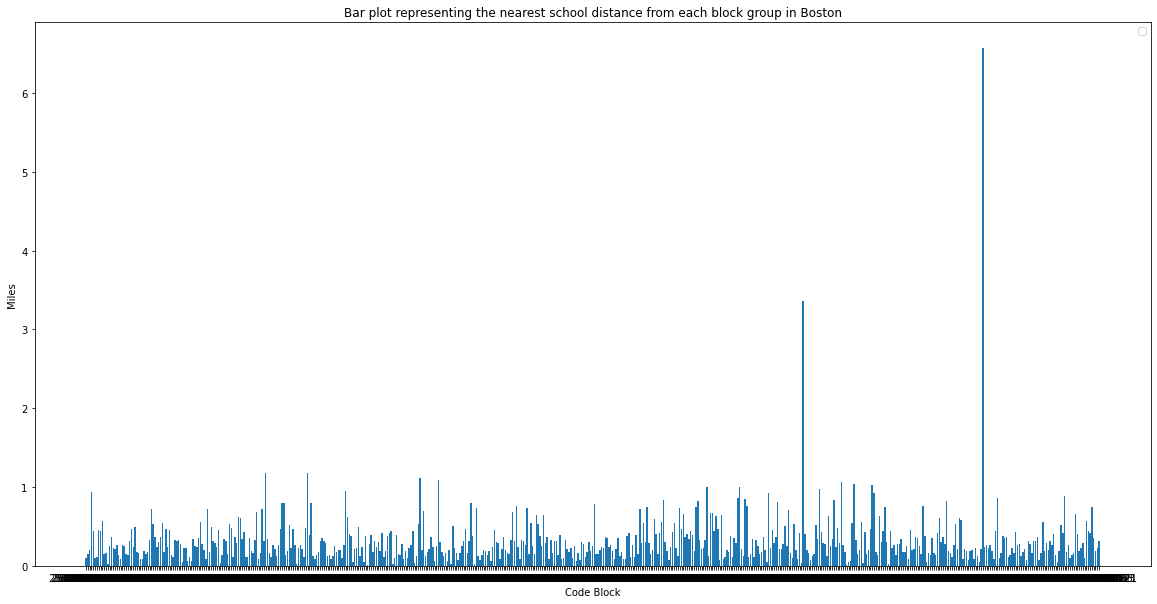

In [ ]:
import matplotlib.pyplot as plt

block_group_list = boston_65_and_above_population["GEOID10"].astype(str).to_list()
closest_school_distance = pd.to_numeric(boston_65_and_above_population["closest_school_distance"]).to_list()

plt.figure(figsize=(20, 10))

plt.title(
    "Bar plot representing the nearest school distance from each block group in Boston"
)
plt.legend(labels=['Nearest School Distance'])
plt.xlabel('Code Block')
plt.ylabel('Miles')

plt.bar(block_group_list, closest_school_distance)
plt.show()